<a href="https://colab.research.google.com/github/floriancal/test_descartes_underwriting/blob/main/test_descartes_underwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification on auto-insurance Dataset
The aim of this notebook is to present my work on the given task.


In [4]:
# Mount my Drive to get the files
from __future__ import print_function
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/test_descartes"

Mounted at /content/drive
MEAN_AUTO.csv  predictions.csv	SHELL_AUTO.csv	test_auto.csv  train_auto.csv


In [ ]:
# Module imports
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import  QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [13]:
# Read Test and train files
test_dataset = pd.read_csv('/content/drive/My Drive/test_descartes/test_auto.csv')
train_dataset = pd.read_csv('/content/drive/My Drive/test_descartes/train_auto.csv')

# Dataset pre-process
The aim of this section is to take a first look at the data and prepare it for the different analysis.

In [14]:
# Quick Dataset visualization
train_dataset.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [15]:
# Pre-Processing
# Remove index column  
train_dataset.drop(train_dataset.columns[0], axis=1, inplace=True)
test_dataset.drop(test_dataset.columns[0], axis=1, inplace=True)

# Remove TARGET_AMT, I suppose here that this is not a feature but another 
# target not mentionned on the exercise and probably must not be used for 
# predictions
train_dataset.drop(train_dataset.columns[1], axis=1, inplace=True)
test_dataset.drop(test_dataset.columns[1], axis=1, inplace=True)

train_dataset.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [16]:
# Check for missing values in each columns
col_labels = ['KIDSDRIV','AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'PARENT1',
  'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME', 'CAR_USE', 
  'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 
  'MVR_PTS', 'CAR_AGE', 'URBANICITY']

for c in col_labels:
  no_missing = train_dataset[c].isnull().sum()
  if no_missing > 0:
      print(c)
      print(no_missing)
  else:
      print(c)
      print("No missing values")
      print(' ')

# If we drop every lines with missing values count how much line shall be 
# dropped
i = 0
for line in range(train_dataset.shape[0]):
  for c in col_labels:
     missing_val = pd.isnull(train_dataset[c][line])
     if missing_val is True:
       i += 1
fraction_lost = i / train_dataset.shape[0]
print('Total lines with missing value over total lines (%) : ',
      fraction_lost * 100)

KIDSDRIV
No missing values
 
AGE
6
HOMEKIDS
No missing values
 
YOJ
454
INCOME
445
PARENT1
No missing values
 
HOME_VAL
464
MSTATUS
No missing values
 
SEX
No missing values
 
EDUCATION
No missing values
 
JOB
526
TRAVTIME
No missing values
 
CAR_USE
No missing values
 
BLUEBOOK
No missing values
 
TIF
No missing values
 
CAR_TYPE
No missing values
 
RED_CAR
No missing values
 
OLDCLAIM
No missing values
 
CLM_FREQ
No missing values
 
REVOKED
No missing values
 
MVR_PTS
No missing values
 
CAR_AGE
510
URBANICITY
No missing values
 
Total lines with missing value over total lines (%) :  29.46942776620512


In [17]:
# Util function
def map_dollar_to_float(x):
  """Convert an input string of the format $xx,xx to a float of value xx.xx
  if x is a float do nothing and return x
  """
  if type(x) == str:  
    x = x.lstrip('$')
    x = x.replace(',', '.')
    x = float(x)
  return x

30% of lines have at least one missing value, if we choose to drop each lines with missing values we will lose a lot of data, then we will impute each line with missing values in the next script.

In [18]:
# 30% is a lot so we choose an imputing strategy for each line with missing 
# value(s)

# For numerical data we choose mean strategy
# For the test set we use transform and not fit cause it will result in a leak
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_dataset[['AGE']] = imputer.fit_transform(train_dataset[['AGE']])
test_dataset[['AGE']] = imputer.transform(test_dataset[['AGE']])

# For numerical data we choose mean strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_dataset[['YOJ']] = imputer.fit_transform(train_dataset[['YOJ']])
test_dataset[['YOJ']] = imputer.transform(test_dataset[['YOJ']])

# Dollar string in dataset are actually numerical values so we convert to float
train_dataset['INCOME'] = train_dataset['INCOME'].map(map_dollar_to_float)
train_dataset['HOME_VAL'] = train_dataset['HOME_VAL'].map(map_dollar_to_float)

test_dataset['INCOME'] = test_dataset['INCOME'].map(map_dollar_to_float)
test_dataset['HOME_VAL'] = test_dataset['HOME_VAL'].map(map_dollar_to_float)

# Some features have no missing values but are numerical dollar so we map them 
train_dataset['BLUEBOOK'] = train_dataset['BLUEBOOK'].map(map_dollar_to_float)
train_dataset['OLDCLAIM'] = train_dataset['OLDCLAIM'].map(map_dollar_to_float)

test_dataset['BLUEBOOK'] = test_dataset['BLUEBOOK'].map(map_dollar_to_float)
test_dataset['OLDCLAIM'] = test_dataset['OLDCLAIM'].map(map_dollar_to_float)

# Then we can impute with mean strategy again
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_dataset[['INCOME']] = imputer.fit_transform(train_dataset[['INCOME']])
test_dataset[['INCOME']] = imputer.transform(test_dataset[['INCOME']])

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_dataset[['HOME_VAL']] = imputer.fit_transform(train_dataset[['HOME_VAL']])
test_dataset[['HOME_VAL']] = imputer.transform(test_dataset[['HOME_VAL']])

# Job is nominal data so we impute it with most frequent mode
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train_dataset[['JOB']] = imputer.fit_transform(train_dataset[['JOB']])
test_dataset[['JOB']] = imputer.transform(test_dataset[['JOB']])

# Car Age is imputed with mean strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_dataset[['CAR_AGE']] = imputer.fit_transform(train_dataset[['CAR_AGE']])
test_dataset[['CAR_AGE']] = imputer.transform(test_dataset[['CAR_AGE']])

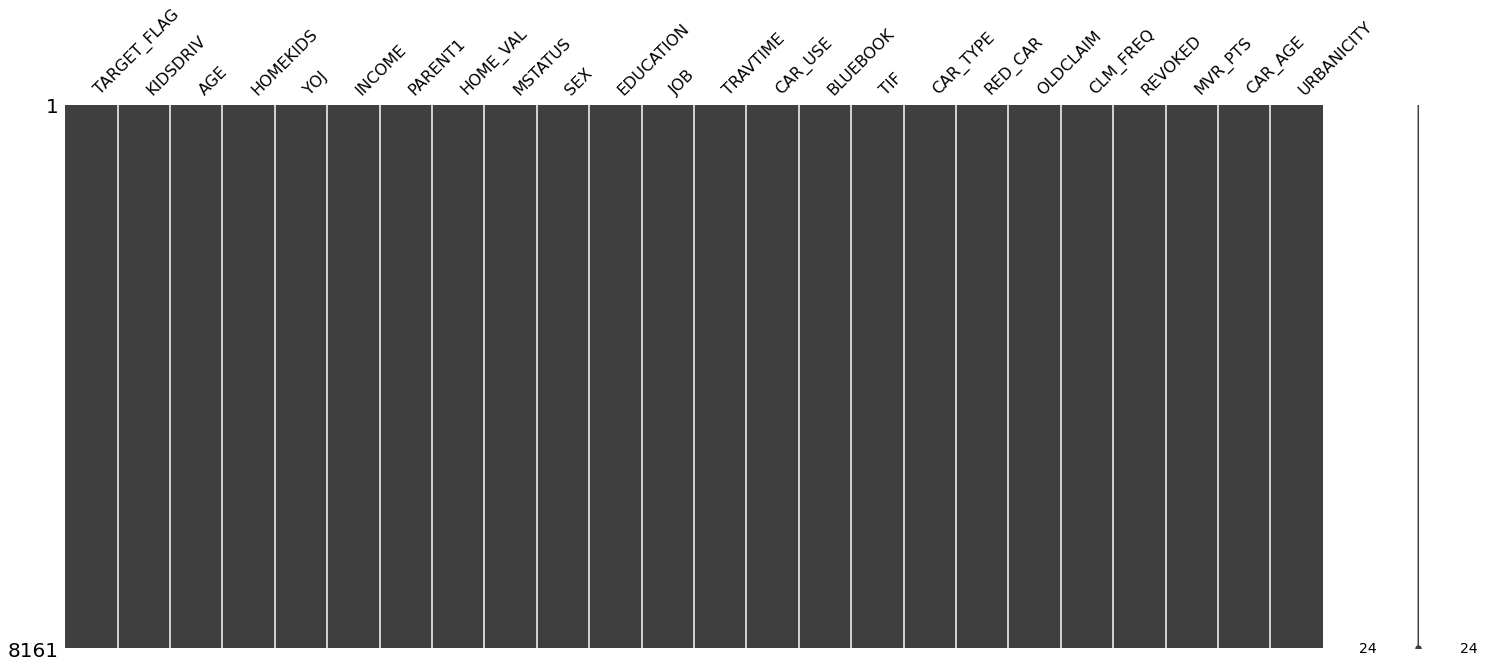

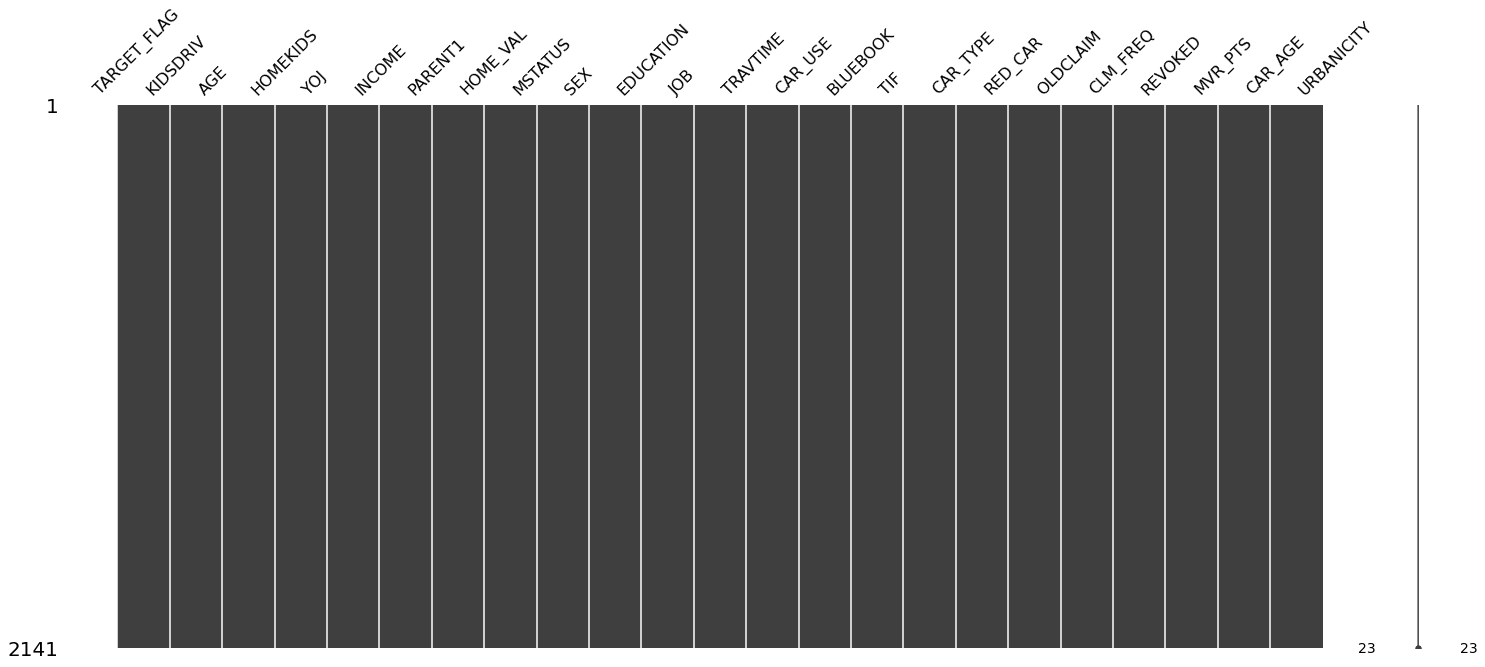

In [19]:
# Check that data has no missing values anymore
msno.matrix(train_dataset)
msno.matrix(test_dataset)

We choose mean imputing strategy by default for numerical values, however if the data is very dispersed, then median strategy might be a better choice. 

The next script aims to look closer at the data to check for this.

Finally, we left mean strategy (mean and median being close each time).

In [20]:
# Compute some stat data to see if some of them seems very dispersed 
# and could lead us to chose median strategy for some imputings

# It seems ok so we stay on mean
print(np.sqrt(np.var(train_dataset['AGE']))) # STD
print(np.max(train_dataset['AGE'])) # MAX
print(np.min(train_dataset['AGE'])) # MIN
print(np.mean(train_dataset['AGE'])) # MEAN
print(np.median(train_dataset['AGE'])) # MEDIAN

print(np.sqrt(np.var(train_dataset['YOJ'])))
print(np.max(train_dataset['YOJ']))
print(np.min(train_dataset['YOJ']))
print(np.mean(train_dataset['YOJ']))
print(np.median(train_dataset['YOJ']))

print(np.sqrt(np.var(train_dataset['INCOME'])))
print(np.max(train_dataset['INCOME']))
print(np.min(train_dataset['INCOME']))
print(np.mean(train_dataset['INCOME']))
print(np.median(train_dataset['INCOME']))

print(np.sqrt(np.var(train_dataset['CAR_AGE'])))
print(np.max(train_dataset['CAR_AGE']))
print(np.min(train_dataset['CAR_AGE']))# car age of -3 is present in the data????
print(np.mean(train_dataset['CAR_AGE']))
print(np.median(train_dataset['CAR_AGE']))

8.623888556185706
81.0
16.0
44.79031269160024
45.0
3.976754322149013
23.0
0.0
10.499286363046595
11.0
59.08461726345284
997.0
0.0
64.75785510627242
57.912
5.519381945456724
28.0
-3.0
8.328323095020215
8.32832309502026


The previous script shown a min car age of -3 which seems impossible.

In [ ]:
# Car age of -3 seems like a corrupted data not knowing more on the dataset
# We check how many times a negative car age is present in the dataset

# Happens once in train dataset
print(len(train_dataset[(train_dataset['CAR_AGE']<0)]))

# Happens zero times in test dataset
print(len(test_dataset[(train_dataset['CAR_AGE']<0)]))

# So i chosed simply to drop the line
train_dataset = train_dataset.drop(train_dataset[train_dataset.CAR_AGE < 0].index)

In [23]:
# We can now divide the datasets into features and target (X and y)
X_train_frame = train_dataset[['KIDSDRIV','AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
  'PARENT1', 'HOME_VAL','MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME',
  'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM', 'CLM_FREQ',
  'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY']]
y_train_frame = train_dataset['TARGET_FLAG']

X_valid_frame = test_dataset[['KIDSDRIV','AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
  'PARENT1', 'HOME_VAL','MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME',
  'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM', 'CLM_FREQ',
  'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY']]

**Data Encoding**

We choose to encode categorical data into one hot vector for multi-modal data
to avoid learning an order between the classes. For binary features we choose an ordinal encoder.


In [24]:
# Now we need to convert nominal data to numerical we choose one hot encoding
# for feature  with more than two modes and ordinal for 2 modes feature
column_trans = make_column_transformer((OneHotEncoder(handle_unknown='error'),
                                        ['EDUCATION', 'JOB', 'CAR_TYPE']),
                                      (OrdinalEncoder(),
                                       ['PARENT1', 'MSTATUS','SEX', 'CAR_USE',
                                        'RED_CAR','REVOKED','URBANICITY' ]),
                                       remainder = 'passthrough', )

# We fit the transformation to the train set
X_train = column_trans.fit_transform(X_train_frame)
y_train = y_train_frame

# The test set follows and it is transformed the same way
X_valid = column_trans.transform(X_valid_frame)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


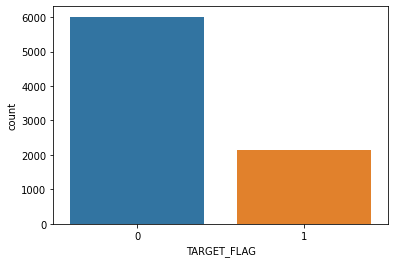

In [ ]:
# Class balance is shown on the next graph we have a ratio of 1:3 which is 
# already an unmbalanced problem
sns.countplot(train_dataset['TARGET_FLAG'], label="Sum")
plt.show()

# Models and pre-processing evaluation
Starting from here we will use pipelines to test different configurations of pre-processing and models. 
All strategies will be evaluated with the same metrics.

In [46]:
# Since we have less than 10k rows I choose to oversample to reduce the unbalancy
# We can Random oversample

# sampling_strategy=0.8 is purely arbitrary and might not be the best compromise
ros = RandomOverSampler(sampling_strategy=0.8)

# Or Smote
smote = SMOTE()

# Adiitionaly we can define a normalizer for data
l2normalize = Normalizer(norm='l2')

We choose to use 9 classic models to evaluate them.

We will use cross validation on 5 k-folds.

We defined 3 metrics: 'accuracy',  'f1_weighted', 'roc_auc',

Accuracy is not well suited for unbalanced dataset, that's why we use a weighted version of F1-score, furthermore roc_auc is a good metric for unbalanced datasets. 

That's why this metric will be our principal to choose models.






In [26]:
# It is important to use this pipeline cause it can upsample data and also
# it avoids to first  upsample the data and then divide into k-folds instead we:
# split into training and validation folds. Then, 
  #1. Oversample the minority class
  #2. Train the classifier on the training folds
  #3. Validate the classifier on the remaining fold

# Define k-folds strategy once for all
kf = KFold(n_splits=5, shuffle=True)

# Model that we choose to evaluate
LR = LogisticRegression()
dtree = DecisionTreeClassifier()
SVM = SVC(probability = True)
LDA = LinearDiscriminantAnalysis()
QDA = QuadraticDiscriminantAnalysis()
RF = RandomForestClassifier()
KNN = KNeighborsClassifier()
GB =  GradientBoostingClassifier()
bayes = GaussianNB()

# Defining metrics
scoring = ['accuracy', 'f1_weighted', 'roc_auc']

In [ ]:
# First we test all models with no normalization no upsampling and default params

# Defining the executing function
def CV_method(pipeline):
  """ Takes a pipeline as input perform the cross validation with data and 
  parameters define above and return accuracy, f1_weighted and roc_auc metrics
  (mean on each folds)"""

  scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=kf)
  sorted(scores.keys())
  accuracy = scores['test_accuracy'].mean()
  f1 = scores['test_f1_weighted'].mean()
  roc = scores['test_roc_auc'].mean()
  return accuracy, f1, roc

# LR
pipeline = Pipeline([('model', LR)])
LR_accuracy, LR_f1, LR_roc = CV_method(pipeline)

# Decision Tree
pipeline = Pipeline([('model', dtree)])
dtree_accuracy, dtree_f1, dtree_roc = CV_method(pipeline)

# SVM
pipeline = Pipeline([('model', SVM)])
SVM_accuracy, SVM_f1, SVM_roc = CV_method(pipeline)

# LDA
pipeline = Pipeline([('model', LDA)])
LDA_accuracy, 
LDA_f1, LDA_roc = CV_method(pipeline)

# QDA
pipeline = Pipeline([('model', QDA)])
QDA_accuracy, QDA_f1, QDA_roc = CV_method(pipeline)

# RF
pipeline = Pipeline([('model', RF)])
RF_accuracy, RF_f1, RF_roc = CV_method(pipeline)

# KNN 
pipeline = Pipeline([('model', KNN)])
KNN_accuracy, KNN_f1, KNN_roc = CV_method(pipeline)

# GB
pipeline = Pipeline([('model', GB)])
GB_accuracy, GB_f1, GB_roc = CV_method(pipeline)

# Bayes
pipeline = Pipeline([('model', bayes)])
bayes_accuracy, bayes_f1, bayes_roc = CV_method(pipeline)

# Baseline Results
The table below gives us the baseline results that we will try to enhance.

In [ ]:
# We can print the results on this table
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'GBoost', 'Bayes'],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, QDA_accuracy, RF_accuracy, KNN_accuracy, GB_accuracy, bayes_accuracy],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, QDA_f1, RF_f1, KNN_f1, GB_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, QDA_roc, RF_roc, KNN_roc, GB_roc, bayes_roc],
    }, columns = ['Model', 'Accuracy', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='AUC_ROC', ascending=False)

,Model,Accuracy,F1_score,AUC_ROC
7,GBoost,0.793995,0.775505,0.821394
3,Linear Discriminant Analysis,0.785172,0.767100,0.805511
5,Random Forest,0.784191,0.759033,0.805424
8,Bayes,0.734926,0.744749,0.774640
0,Logistic Regression,0.763725,0.737920,0.767968
2,Support Vector Machine,0.735784,0.624446,0.737377
4,Quadratic Discriminant Analysis,0.660417,0.663085,0.705769
1,Decision Tree,0.703554,0.703987,0.619618
6,K-Nearest Neighbors,0.713358,0.677979,0.610190


# We will perform Grid Searching for the best parameters. 
The grid searching will focus on two parts, first when it's possible we will tweak the class_weight parameters because it is a key factor of our problem.
Then we will tweak classical parameters of each method.


In [ ]:
# Now that we have a baseline we can try grid searching better parameters
def Grid_search_method(pipeline, params):
  """ Takes a pipeline and parameters to perform a grid search then return
  the best parameters (for roc_auc metric) and their score """

  new_params = {'model__' + key: params[key] for key in params}
  grid = GridSearchCV(pipeline, param_grid=new_params, cv=kf, scoring=scoring,
                        refit='roc_auc', return_train_score=True)
  grid.fit(X_train, y_train)
  return grid.best_params_, grid.best_score_

# We have an unbalanced problem so giving weight to class is a good idea.
# The grid searchs below aims to test different values of this strategy with
# classical tuning of hyperparameters of each method.
# We do not focus on regularization because we have almost 10k rows for 
# 40 one encoded features
pipeline = Pipeline([('model', LR)])
params = {'class_weight': [None, 'balanced', {0: 0.5, 1: 1},  {0: 0.8, 1: 0.5, 0: 0.3}], 'solver' : ['newton-cg', 'lbfgs', 'liblinear'], 'max_iter': [300]}
LRbest_params_, LRbest_score_  = Grid_search_method(pipeline, params)

# Again class weight is the main focus with some of the method key hyperparams
pipeline = Pipeline([('model', dtree)])
params = {'class_weight': [None, 'balanced', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'criterion': ['gini','entropy'], 'max_depth': [3, 5, 7, 9, 13, 15]}
dtreebest_params_, dtreebest_score_ = Grid_search_method(pipeline, params)

# Again class weight is the main focus with some of the method key hyperparams
pipeline = Pipeline([('model', SVM)])
params = {'class_weight': [None, 'balanced', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3, 4, 5]}
SVMbest_params_, SVMbest_score_ = Grid_search_method(pipeline, params)

# in LDA priors parameter : 
# The class prior probabilities. By default, the class proportions are inferred 
# from the training data
# this mean by default this method takes into account class distribution,
# this might explain the good performance of the model on the baseline above
# We will only play on solver and shrinkage
pipeline = Pipeline([('model', LDA)])
params = {'solver': ['svd', 'lsqr', 'eigen'], 'shrinkage': ['auto', None] }
LDAbest_params_, LDAbest_score_ = Grid_search_method(pipeline, params)

# Same as LDA except for the good performance..
pipeline = Pipeline([('model', QDA)])
params = {'reg_param': [0, 1, 2, 3]}
QDAbest_params_, QDAbest_score_ = Grid_search_method(pipeline, params)

# Again class weight is the main focus with some of the method key hyperparams
pipeline = Pipeline([('model', RF)])
params = {'class_weight': [None, 'balanced', 'balanced_subsample', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'n_estimators': [100, 200, 300], 'criterion': ['gini', 'entropy']}
RFbest_params_, RFbest_score_ = Grid_search_method(pipeline, params)

# No class weight available, so tweaking hyparams
pipeline = Pipeline([('model', KNN)])
params = {'n_neighbors': [2, 3, 4, 5, 6], 'weights': ['uniform', 'distance']}
KNNbest_params_, KNNbest_score_ = Grid_search_method(pipeline, params) 

# We are going a bit deeper on this parameter search because it is our best model
# so far so worst investing commputing time
pipeline = Pipeline([('model', GB)])
params = {'loss': ['deviance', 'exponential'], 'learning_rate': [0.05, 0.1, 0.2], 'n_estimators' : [100, 200, 400, 600], 'criterion': ['friedman_mse', 'mse', 'mae']}
GBbest_params_, GBbest_score_ = Grid_search_method(pipeline, params)

pipeline = Pipeline([('model',  bayes)])
params = {}
bayesbest_params_, bayesbest_score_ = Grid_search_method(pipeline, params)

# Grid Searching results :
Because some grid searchig took too long we drop some of the calculations (result of 0 in the table), however none of the models outperformed default parameters of Gradient boosting method. and the other model dropped were not in the top 3..

In [10]:
SVMbest_score_ = 0
GBbest_score_ = 0
QDAbest_score_ = 0

In [11]:
grid_search_wout_oversample_wout_normalize = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'GBoost', 'Bayes'],
    'AUC_ROC'     : [LRbest_score_, dtreebest_score_, SVMbest_score_, LDAbest_score_, QDAbest_score_, RFbest_score_, KNNbest_score_, GBbest_score_, bayesbest_score_],
    }, columns = ['Model', 'AUC_ROC'])
grid_search_wout_oversample_wout_normalize.sort_values(by='AUC_ROC', ascending=False)

,Model,AUC_ROC
5,Random Forest,0.814634
0,Logistic Regression,0.805863
3,Linear Discriminant Analysis,0.803493
8,Bayes,0.774640
1,Decision Tree,0.744547
6,K-Nearest Neighbors,0.621600
2,Support Vector Machine,0.000000
4,Quadratic Discriminant Analysis,0.000000
7,GBoost,0.000000


We can now do the same with oversampling and/or normalization.

Since the previous calculations was computationally expensive, we will focus only on the 3 best models so far plus Gboost which was not computed on the previous step.

We might drop a good candidate, but we must make choices.

We will grid search onlyo on class_weight since it is strongly linked with oversampling.

For the other parameters we will use the best parameters that we found above.

Again we might not consider the best solution but we will save computation time.



In [ ]:
# We can apply our preprocessing  to see the results variations

# With SMOTE and normalize
#LR
pipeline = Pipeline([('upsampler', smote), ('normalizer',l2normalize), ('model', LR)])
params ={'class_weight': [None, 'balanced', 'balanced_subsample', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'max_iter': [300] , 'solver': ['liblinear']}
LR_best_params_SN, LR_roc_SN = Grid_search_method(pipeline, params)

# LDA
pipeline = Pipeline([('upsampler', smote), ('normalizer',l2normalize), ('model', LDA)])
params = {'shrinkage': [None], 'solver': ['lsqr']}
LDA_best_params_SN, LDA_roc_SN = Grid_search_method(pipeline, params)

# RF
pipeline = Pipeline([('upsampler', smote), ('normalizer',l2normalize), ('model', RF)])
params = {'class_weight': [None, 'balanced', 'balanced_subsample', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'criterion': ['entropy'], 'n_estimators': [300]}
RF_best_params_SN, RF_roc_SN = Grid_search_method(pipeline, params)

# GB
pipeline = Pipeline([('upsampler', smote), ('normalizer',l2normalize), ('model', GB)])
params = { }
GB_best_params_SN, GB_roc_SN = Grid_search_method(pipeline, params)


# With SMOTE only
#LR
pipeline = Pipeline([('upsampler', smote), ('model', LR)])
params ={'class_weight': [None, 'balanced', 'balanced_subsample', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'max_iter': [300] , 'solver': ['liblinear']}
LR_best_params_S, LR_roc_S = Grid_search_method(pipeline, params)

# LDA
pipeline = Pipeline([('upsampler', smote), ('model', LDA)])
params = {'shrinkage': [None], 'solver': ['lsqr']}
LDA_best_params_S, LDA_roc_S = Grid_search_method(pipeline, params)

# RF
pipeline = Pipeline([('upsampler', smote), ('model', RF)])
params = {'class_weight': [None, 'balanced', 'balanced_subsample', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'criterion': ['entropy'], 'n_estimators': [300]}
RF_best_params_S, RF_roc_S = Grid_search_method(pipeline, params)

# GB
pipeline = Pipeline([('upsampler', smote), ('model', GB)])
params = { }
GB_best_params_SN, GB_roc_S = Grid_search_method(pipeline, params)


# With normalize only
#LR
pipeline = Pipeline([('normalizer',l2normalize), ('model', LR)])
params ={'class_weight': [None, 'balanced', 'balanced_subsample', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'max_iter': [300] , 'solver': ['liblinear']}
LR_best_params_N, LR_roc_N = Grid_search_method(pipeline, params)

# LDA
pipeline = Pipeline([('normalizer',l2normalize), ('model', LDA)])
params = {'shrinkage': [None], 'solver': ['lsqr']}
LDA_best_params_N, LDA_roc_N = Grid_search_method(pipeline, params)

# RF
pipeline = Pipeline([('normalizer',l2normalize), ('model', RF)])
params = {'class_weight': [None, 'balanced', 'balanced_subsample', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'criterion': ['entropy'], 'n_estimators': [300]}
RF_best_params_N, RF_roc_N = Grid_search_method(pipeline, params)

# GB
pipeline = Pipeline([('normalizer',l2normalize), ('model', GB)])
params = { }
GB_best_params_N, GB_roc_N = Grid_search_method(pipeline, params)

# Random oversampling alone to compare to smote oversampling alone
#LR
pipeline = Pipeline([('upsampler', ros), ('model', LR)])
params ={'class_weight': [None, 'balanced', 'balanced_subsample', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'max_iter': [300] , 'solver': ['liblinear']}
LR_best_params_R, LR_roc_R = Grid_search_method(pipeline, params)

#LDA
pipeline = Pipeline([('upsampler', ros), ('model', LDA)])
params = {'shrinkage': [None], 'solver': ['lsqr']}
LDA_best_params_R, LDA_roc_R = Grid_search_method(pipeline, params)

# RF
pipeline = Pipeline([('upsampler', ros), ('model', RF)])
params = {'class_weight': [None, 'balanced', 'balanced_subsample', {0: 0.5, 1: 1}, {0: 0.8, 1: 0.5, 0: 0.3}], 'criterion': ['entropy'], 'n_estimators': [300]}
RF_best_params_R, RF_roc_R = Grid_search_method(pipeline, params)

# GB
pipeline = Pipeline([('upsampler', ros), ('model', GB)])
params = { }
GB_best_params_R, GB_roc_R = Grid_search_method(pipeline, params)

# Final results 
Final results are listed below, the best model will be used to make the predictions and write the output csv file.

In [52]:
Final_results = pd.DataFrame({
    'Model'       : [ 'Linear Discriminant Analysis', 'Random Forest','GBoost', 'LR',
                      'Linear Discriminant Analysis + SMOTE + Norm', 'Random Forest + SMOTE + Norm', 'GBoost + SMOTE + Norm','LR + SMOTE + Norm',
                      'Linear Discriminant Analysis + SMOTE', 'Random Forest + SMOTE','GBoost + SMOTE', 'LR + SMOTE',
                      'Linear Discriminant Analysis + Norm', 'Random Forest + Norm','GBoost + Norm', 'LR + Norm', 
                      'Linear Discriminant Analysis + RandomOS', 'Random Forest + RandomOS','GBoost + RandomOS', 'LR + RandomOS' ],
    'AUC_ROC'     : [LDAbest_score_, RFbest_score_, GBbest_score_, LRbest_score_,
                     LDA_roc_SN, RF_roc_SN, GB_roc_SN, LR_roc_SN,
                     LDA_roc_S, RF_roc_S, GB_roc_S, LR_roc_S,
                     LDA_roc_N, RF_roc_N, GB_roc_N, LR_roc_N,
                     LDA_roc_R, RF_roc_R, GB_roc_R, LR_roc_R],
    }, columns = ['Model', 'AUC_ROC'])
Final_results.sort_values(by='AUC_ROC', ascending=False)

,Model,AUC_ROC
18,GBoost + RandomOS,0.818452
10,GBoost + SMOTE,0.818164
1,Random Forest,0.814634
9,Random Forest + SMOTE,0.811449
17,Random Forest + RandomOS,0.810982
14,GBoost + Norm,0.807174
16,Linear Discriminant Analysis + RandomOS,0.806887
8,Linear Discriminant Analysis + SMOTE,0.806536
3,LR,0.805863
19,LR + RandomOS,0.805549


Finally none of the strategy has beaten the clasic Gradient boosting so we will use this to make predictions and write the file.

In [59]:
pipeline = Pipeline([('model', GB)])
params = { }
GB_best_params_, GB_roc_ = Grid_search_method(pipeline, params)
print(GB_roc_)

0.8200631760355156


In [57]:
# We finally use our best solution to write predictions
GB.fit(X_train, y_train)
y_valid = GB.predict(X_valid)

a = np.asarray(y_valid)
np.savetxt("/content/drive/My Drive/test_descartes/predictions.csv", a, delimiter=",")

# THE END
this is the end of this exercise, the predicted file can be found at:
https://github.com/floriancal/test_descartes_underwriting.git

Of course, the results can be enhanced. We might try to do dimensionality reduction because we generated almost 40 columns. It might simplify the models learning and will reduce computation time.

Furthermore, we might try combining our models with voting classifiers for example.

Thanks for reading my work, have a nice day :)